# Final Report : Insert Title Name

## Introduction
As part of a data-collection initiative by the Pacific Laboratory for Artificial Intelligence (PLAI), PLAICraft is a free-use Minecraft server whose goal is to record over 10,000 hours of multiplayer gameplay<!-- (insert citation)-->. One challenge in amassing such large amounts of data is ensuring the pubic remains engaged with the server. As follows, a game-related newsletter was developed to provide players with regular reminders, thereby encouraging continued participation.

However, to fully optimize recruitment efforts, it is necessary to understand which player characteristics are most predictive of subscribing to the PLAICraft newsletter. Therefore, this report seeks to answer the following fundamental question: *Can we predict whether a player subscribes to the PLAICraft newsletter using the player’s age and the total hours they have played?* <!-- reword this later-->

<!-- mention methodology? -->

### Dataset Overview
This project utilizes the `players.csv` dataset, which contains information on 196 (observations) individual players who have participated in the PLAICraft server. As detailed in Table 1, `players.csv` includes 7 variables.

<p style="text-align: center; font-weight: bold;">Table 1: Variables in <code> players.csv </code> </p> <!-- in-line code or no in-linecode -->

| Name                  | Type         | Description                                                                                     |
|-----------------------|--------------|-------------------------------------------------------------------------------------------------|
| `experience`          | factor       | Player’s Minecraft experience level.  <br> (One of `Amateur`, `Regular`, `Pro`, or `Veteran`.)  |
| `subscribe`           | logical      | Indicates whether the player has subscribed to the newsletter. <br> (`TRUE` if subscribed, `FALSE` if not subscribed.)                                                                                                                             |
| `hashedEmail`         | character    | A hashed version of the player's email address.                                                 |
| `played_hours`        | double       | Total number of hours played on PLAICraft.                                                      |
| `name`                | character    | Player’s name.                                                                                  |
| `gender`              | factor       | Player's gender. <br> (One of `Female`, `Male`, `Non-Binary`, `Prefer not to say`.)             |
| `age`                 | integer      | Player’s age                                                                                    |
---

## Methods & Results
---

### Preliminary Wrangling

In [1]:
### Libraries
library(tidyverse) # for data wrangling
library(tidymodels) # for predictive classification
library(themis) # to mitigate effects of class imbalance

### 
set.seed(118) # remove effects of randomness

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Begin by loading in the `players.csv` dataset:

In [2]:
raw_players <- read_csv("data/players.csv", show_col_types = FALSE) # hide output

Perform the following wrangling steps to tidy the data and prepare for $k$-nearest neighbours classification:
1. Rename `hashedEmail` and `Age` with `rename()` for consistency with other column names.
2. Keep only the relevant predictor columns `age`, `played_hours` and the label column `subscribe` using `select()`.
3. Remove `NA` values using `drop_na()`. `NA` values can be assumed to be random rather than informative (DSCI 100 textbook; Timbers et al., 2024).
4. Transform the label `subscribe` from `lgl` to `fct` type with `mutate()` and `as_factor()`.
5. Reassign the default category `"TRUE"` and `"FALSE"` to `"Yes"` and `"No"` to make the answer to the predictive question clearer.

In [3]:
options(repr.matrix.max.rows = 6) # limit to 6 observations for brevity
players <- raw_players |>
    rename("hashed_email" = "hashedEmail", "age" = "Age") |>
    select(age, played_hours, subscribe) |>
    drop_na() |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
players

age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,Yes
17,3.8,Yes
17,0.0,No
⋮,⋮,⋮
22,0.3,No
17,0.0,No
17,2.3,No


Before beginning $k$-nn analysis, obtain some basic summary statistics on `players`:

In [4]:
players_summary <- players |>
    summarize(
        observation_count = n(),
    	min_hours = min(played_hours),
    	max_hours = max(played_hours),
    	mean_hours = mean(played_hours),
    	min_age = min(age), 
    	max_age = max(age),
    	mean_age = mean(age)
    )
players_summary

observation_count,min_hours,max_hours,mean_hours,min_age,max_age,mean_age
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,0,223.1,5.904639,8,50,20.52062


Both the range of values and mean of `played_hours` and `age` differ greatly, so we will have to scale and centre the data to ensure they contribute equally to the Euclidean distance formula used by $k$-nn. 

Next, check for class imbalances:

In [5]:
total_number_of_observations <- nrow(players)
players_classes <- players |>
	group_by(subscribe) |>
	summarize(
		count = n(),
		percentage = n() / total_number_of_observations * 100
        )
players_classes

subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.80412
Yes,142,73.19588


This disparity in the label count suggests that there may be a class imbalance in the data, which affects the quality of $k$-nn predictions since the algorithm relies on the number of close data points. We would expect that $k$-nn would return `Yes` more frequently simply because there are more `Yes` points. To better understand the predictors, visualize the relationship between `age` and `hours`:

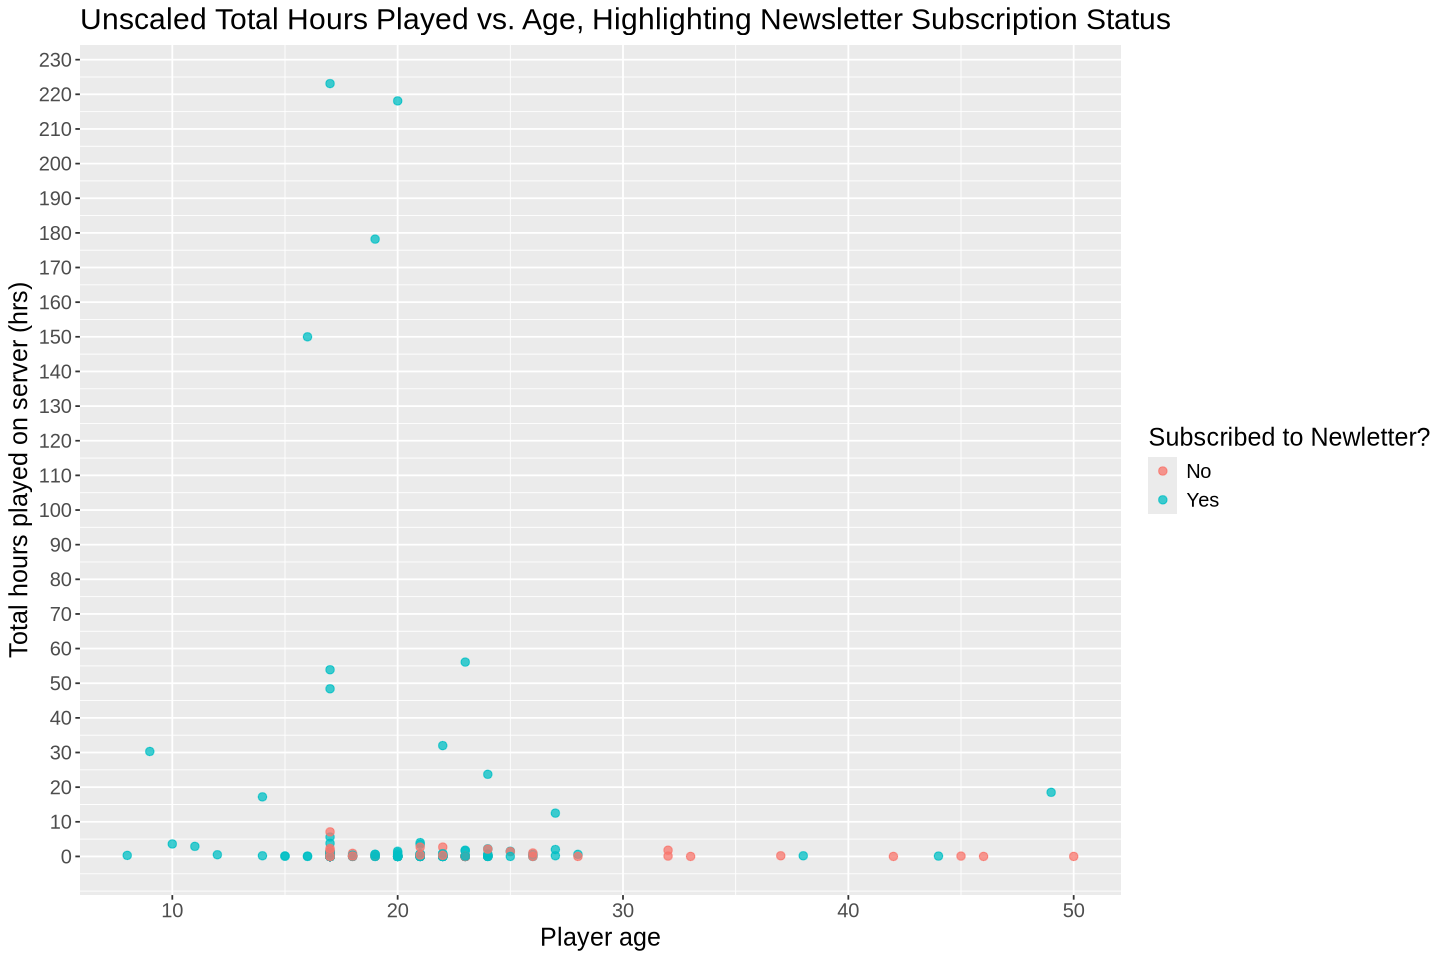

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8) ## Set Graph Size

age_v_hour <- players |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
    geom_point(alpha = 0.75, size = 2) +
    xlab("Player age") +
    ylab("Total hours played on server (hrs)") +
    theme(text = element_text(size = 15)) +
    labs(colour = "Subscribed to Newletter?") +
    scale_y_continuous(
        breaks = seq(0, 250, by = 10),   ## Show Tick by 10 on y axis       
    ) +
    ggtitle("Unscaled Total Hours Played vs. Age, Highlighting Newsletter Subscription Status")

age_v_hour

From this visualization, we can see that the predictors are disproportionate and will require scaling in pre-processing. Now, begin by finding the optimal $k$ through tuning with 5-fold cross-validation using `collect_metrics()` to find their accuracies:

In [7]:
options(repr.matrix.max.rows = 6) # reduce display of data for brevity

### Create an 80/20 training/testing data split
players_split <- initial_split(players, prop = 0.80, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

### Training recipe
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_scale(all_predictors()) |> # scale data
    step_center(all_predictors()) |> # centre data
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) 
    # this function from themis oversamples the No class to mitigate class imbalance
    # skip is set to TRUE, since we only want to oversample on training folds


### Specify the tuning model
training_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(training_spec) |>
    tune_grid(resamples = players_vfold,
              grid = k_vals,
              metrics = metric_set(accuracy, recall, precision)) |>
    collect_metrics() 
knn_results

### Find best K for Accuracy, Precision, and Recall.
optimal_k_df <- knn_results |>
    group_by(.metric) |>
    slice_max(mean, n = 1) |>
    select(.metric, neighbors, mean)
optimal_k_df

optimal_k_accuracy <- optimal_k_df |>
    ungroup() |>
    filter(.metric == "accuracy") |>
    select(neighbors) |>
    pull()

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4993548,5,0.0289497,Preprocessor1_Model01
1,precision,binary,0.2424673,5,0.0422692,Preprocessor1_Model01
1,recall,binary,0.4638889,5,0.1074573,Preprocessor1_Model01
⋮,⋮,⋮,⋮,⋮,⋮,⋮
96,accuracy,binary,0.4412769,5,0.01981532,Preprocessor1_Model20
96,precision,binary,0.2429098,5,0.02356192,Preprocessor1_Model20
96,recall,binary,0.5583333,5,0.10341395,Preprocessor1_Model20


.metric,neighbors,mean
<chr>,<dbl>,<dbl>
accuracy,66,0.5189113
precision,16,0.2958989
recall,31,0.7361111


As such, 5-fold cross validation suggests that the optimal number of neighbours, prioritizing accuracy, is $K = 66$. Proceed by evaluating on the test set using this value, generating metrics and a confusion matrix:

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k_accuracy) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

players_test_predictions <- predict(knn_fit, players_test)|>
    bind_cols(players_test)

players_test_metrics <- bind_rows(
    players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class) |>
        filter(.metric == "accuracy"),
    
    players_test_predictions |>
        precision(truth = subscribe, estimate = .pred_class, event_level = "first"),
    
    players_test_predictions |>
        recall(truth = subscribe, estimate = .pred_class, event_level = "first")
)

players_test_metrics
confusion_matrix <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725
precision,binary,0.500
recall,binary,1.000


          Truth
Prediction No Yes
       No  11  11
       Yes  0  18

Finally, perform $k$-nn analysis on the full `players` dataset:

In [9]:
options(repr.matrix.max.rows = 20)

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players)

players_predictions <- predict(players_fit, players) |>
    bind_cols(players) |>
    select(age, played_hours, subscribe, .pred_class) # reorder columns
players_predictions

age,played_hours,subscribe,.pred_class
<dbl>,<dbl>,<fct>,<fct>
9,30.3,Yes,Yes
17,3.8,Yes,Yes
17,0.0,No,Yes
21,0.7,Yes,Yes
21,0.1,Yes,Yes
17,0.0,Yes,Yes
19,0.0,Yes,No
21,0.0,No,Yes
17,0.1,Yes,Yes


To better understand the metric trends with $K$, plot the performance curves for accuracy, recall, and precision.

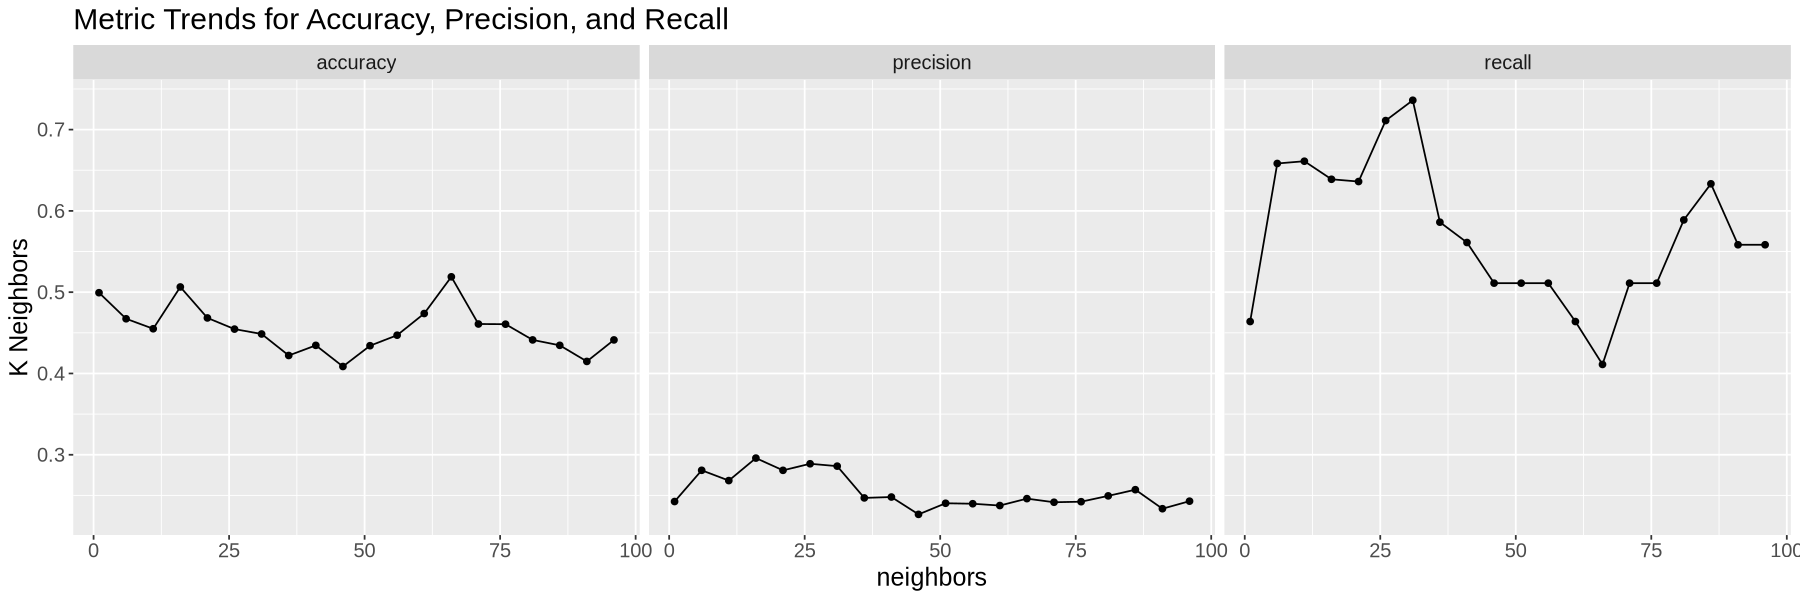

In [10]:
options(repr.plot.width = 15, repr.plot.height = 5)
metric_trends <- knn_results|>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    facet_wrap(facets = vars(.metric)) +
    ylab("K Neighbors") +
    ggtitle("Metric Trends for Accuracy, Precision, and Recall") + 
    theme(text = element_text(size = 15))
metric_trends

## Discussion
---

## References
---

Timbers, T., Campbell, T., & Lee, M. (2024). Data Science. In datasciencebook.ca. CRC Press/Taylor & Francis. https://datasciencebook.ca/index.html